<a href="https://colab.research.google.com/github/jmoranrun/HAR_Dist_ML/blob/main/Incremental_Shifting_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%tensorflow_version 1.14
import numpy as np
import random 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.utils import plot_model
 
 
 
# load a single file as a numpy array
def load_file(filepath):
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
  return dataframe.values

#######################################################################
# Function to move selected test samples to traning dataset
# Lots of parameters - however, these are driven by a higher level
# function (select_user_val), which has a more user friendly parameter list
#######################################################################
def move_test_to_train(move_samples, move_sub_map, move_ys, move_idx, har_dataset_user_test, har_submap_user_test, har_dataset_user_train, har_submap_user_train, har_y_user_test, har_y_user_train):
    har_dataset_user_test = np.asarray(har_dataset_user_test)
    har_submap_user_test = np.asarray(har_submap_user_test)
    har_dataset_user_train = np.asarray(har_dataset_user_train)
    har_submap_user_train = np.asarray(har_submap_user_train)
    har_y_user_test = np.asarray(har_y_user_test)
    har_y_user_train = np.asarray(har_y_user_train)
    move_samples = np.asarray(move_samples)
    move_ys = np.asarray(move_ys)
    har_dataset_user_test = np.delete(har_dataset_user_test, move_idx, axis=0)
    har_submap_user_test = np.delete(har_submap_user_test, move_idx, axis=0)
    har_y_user_test = np.delete(har_y_user_test, move_idx, axis=0)
    har_dataset_user_train = np.concatenate((har_dataset_user_train, move_samples))
    har_submap_user_train = np.concatenate((har_submap_user_train, move_sub_map))
    har_y_user_train = np.concatenate((har_y_user_train, move_ys))
    return  har_dataset_user_test, har_submap_user_test, har_y_user_test, har_dataset_user_train, har_submap_user_train, har_y_user_train
 
#############################################################################################
# Function to create a user dataset
# har_dataset is a 3-D np array of form: [num_of_samples, num_of_timesamples, num_of_feature]
#             Where num_of_samples is the total number of recorded activites 
#                   num_of_timesamples is the total number of timesammples in each recorded activity 
#                   num_of_feature is the total number of features recorded using the smartphones.
# sub_map maps subjects (people) to each har_dataset sample
# test_user lists which subjects are assigned to the test dataset
# train_user lists which subjects are assigned to the training dataset
# percent_mix determines the percentage of the test dataset samples to move into the training dataset
#############################################################################################
def select_user_val(har_dataset, y, sub_map, test_users, train_user, percent_mix):
  har_dataset_user_test=[]
  har_submap_user_test=[]
  har_y_user_test=[]
  for user in test_users:
  #  har_dataset_user_test.append(har_dataset[tuple(np.where(sub_map==user))]) 
    har_dataset_user_test.extend(har_dataset[tuple(np.where(sub_map==user))].tolist()) 
    har_submap_user_test.extend(sub_map[np.where(sub_map==user)].tolist())
    har_y_user_test.extend(y[tuple(np.where(sub_map==user))].tolist()) 
  # Generate the default training dataset 
  har_dataset_user_train=[]
  har_submap_user_train=[]
  har_y_user_train=[]
  for user in train_user:
    har_dataset_user_train.extend(har_dataset[tuple(np.where(sub_map==user))].tolist())
    har_submap_user_train.extend(sub_map[np.where(sub_map==user)].tolist())
    har_y_user_train.extend(y[tuple(np.where(sub_map==user))].tolist()) 
 
  ## Now allow a percentage of val users samples to enter the training dataset
  ## Make sure that the percentage comes from each val user
 
  for user in test_users:
    har_user_sub_map=np.where(np.asarray(har_submap_user_test)==user)[0]
    har_user_sub_map_cnt=np.count_nonzero(np.asarray(har_submap_user_test)==user)
    num_take_sub_map = int(har_user_sub_map_cnt*percent_mix)
    if(num_take_sub_map > 0) :
      move_idx=random.sample(list(har_user_sub_map), num_take_sub_map)
      move_samples=[har_dataset_user_test[i] for i in move_idx]  
      move_sub_map=[har_submap_user_test[i] for i in move_idx]   
      move_ys=[har_y_user_test[i] for i in move_idx]   
      har_dataset_user_test, har_submap_user_test, har_y_user_test, har_dataset_user_train, har_submap_user_train, har_y_user_train \
        = move_test_to_train(move_samples, move_sub_map, move_ys, move_idx, har_dataset_user_test, har_submap_user_test, har_dataset_user_train, har_submap_user_train, har_y_user_test, har_y_user_train)
  return  np.asarray(har_dataset_user_test), np.asarray(har_submap_user_test), np.asarray(har_y_user_test), np.asarray(har_dataset_user_train), np.asarray(har_submap_user_train), np.asarray(har_y_user_train)
 
 
## This files contains the training users mapping
sub_map_train = load_file('/content/drive/My Drive/Colab Notebooks/UCI_dataset/UCI HAR Dataset/train/subject_train.txt')
train_subjects = np.unique(sub_map_train)
print(train_subjects)
 
sub_map_test = load_file('/content/drive/My Drive/Colab Notebooks/UCI_dataset/UCI HAR Dataset/test/subject_test.txt')
test_subjects = np.unique(sub_map_test)
print(test_subjects)
 
 
har_features = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]
 
num_of_timesamples = 128
num_of_feature = len(har_features)
num_of_samples = sub_map_train.shape[0] + sub_map_test.shape[0]
print("num_of_samples is",num_of_samples)

sub_map = np.concatenate((sub_map_test, sub_map_train), axis =0)
sub_map = sub_map.reshape(-1) 
print(sub_map)
unique, counts = np.unique(sub_map, return_counts=True)
print(dict(zip(unique, counts)))
 
har_feature_cnt=0
har_dataset =  np.empty([num_of_samples, num_of_timesamples, num_of_feature])
for har_feature in har_features:
   har_feature_test  = load_file(f'/content/drive/My Drive/Colab Notebooks/UCI_dataset/UCI HAR Dataset/test/Inertial Signals/{har_feature}_test.txt')
   har_feature_train = load_file(f'/content/drive/My Drive/Colab Notebooks/UCI_dataset/UCI HAR Dataset/train/Inertial Signals/{har_feature}_train.txt')
   har_feature = np.concatenate((har_feature_test, har_feature_train), axis=0)
   har_dataset[:, :, har_feature_cnt] = har_feature 
   har_feature_cnt += 1
 
 
har_dataset_with_subject = np.expand_dims(har_dataset, axis=1)
print("har_dataset_with_subject.shape is",har_dataset_with_subject.shape)
 
x_concat = har_dataset
 
train_y =  load_file('/content/drive/My Drive/Colab Notebooks/UCI_dataset/UCI HAR Dataset/train/y_train.txt')
test_y =  load_file('/content/drive/My Drive/Colab Notebooks/UCI_dataset/UCI HAR Dataset/test/y_test.txt')
 


train_y = np.asarray(pd.get_dummies(train_y.reshape(-1, )))
test_y = np.asarray(pd.get_dummies(test_y.reshape(-1, )))
y_concat = np.concatenate((test_y,train_y),axis=0)
  
# set variables
seg_len = 128
num_channels = 9
num_labels = 6
batch_size = 100
learning_rate = 0.001
num_epoches = 60
#num_batches = train_x.shape[0] // batch_size
time_samples = 128
feature_sensors = 9
num_classes = 6
 
 
 
########################################
###### Define the CNN Model ############
########################################
 

opt = 'sgd'
model_har = Sequential()
model_har.add(Conv1D(filters=32,kernel_size=10,strides=1,activation='relu', input_shape=(time_samples, feature_sensors)))
model_har.add(MaxPooling1D(pool_size=4,strides=2, padding='same'))
model_har.add(Conv1D(filters=64,kernel_size=2,strides=1,activation='relu'))
model_har.add(Flatten())
model_har.add(Dense(50))
model_har.add(Activation('tanh'))
model_har.add(Dropout(0.6))
model_har.add(Dense(num_labels))
model_har.add(Activation('softmax'))
 


 
 
model_har.compile(loss='categorical_crossentropy',
              optimizer=opt, metrics=['accuracy'])
model_har.save_weights('/content/drive/My Drive/model_har_init.h5')
print(model_har.summary())

Mounted at /content/drive
`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


Using TensorFlow backend.


[ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]
[ 2  4  9 10 12 13 18 20 24]
num_of_samples is 10299
[ 2  2  2 ... 30 30 30]
{1: 347, 2: 302, 3: 341, 4: 317, 5: 302, 6: 325, 7: 308, 8: 281, 9: 288, 10: 294, 11: 316, 12: 320, 13: 327, 14: 323, 15: 328, 16: 366, 17: 368, 18: 364, 19: 360, 20: 354, 21: 408, 22: 321, 23: 372, 24: 381, 25: 409, 26: 392, 27: 376, 28: 382, 29: 344, 30: 383}
har_dataset_with_subject.shape is (10299, 1, 128, 9)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 119, 32)           2912      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 60, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 59, 64)

In [ ]:

def run_mix(model_har, percent_mix_end = .5, percent_mix_num_samples = 10, num_of_mix_runs = 30, mix_users=False, compile_mode="incremental_compile"):
  percent_mix_values = np.linspace(0, percent_mix_end, percent_mix_num_samples)
  total_num_users=30
  all_users = range(1, total_num_users)
  test_users = random.sample(all_users, 13)
  train_user=np.setdiff1d(all_users, test_users)
  acc_result=np.zeros([percent_mix_num_samples, num_of_mix_runs])
  train_users_lst=[]
  test_users_lst=[]
  x_train_shape_lst=[]
  x_test_shape_lst=[]

  for mix_run in range(num_of_mix_runs):
    percent_mix_run=0
    all_users = range(1, total_num_users)
    test_users = random.sample(all_users, 13)
    model_har.load_weights('/content/drive/My Drive/model_har_init.h5')
    train_users=np.setdiff1d(all_users, test_users)
    for percent_mix in  percent_mix_values:
      tf.keras.backend.clear_session
      if(percent_mix_run != 0):
         if(compile_mode == "recompile"):
             model_har.load_weights('/content/drive/My Drive/model_har_init.h5')  
         elif(compile_mode == "incremental_compile"):     
             model_har.load_weights('/content/drive/My Drive/model_har_inc.h5')  
      print("test_users are", test_users)
      print("train_users are", train_users)
      train_users_lst.append(train_users)
      test_users_lst.append(test_users)
      har_dataset_user_test, har_submap_user_test, har_y_user_test, har_dataset_user_train, har_submap_user_train, har_y_user_train = \
      select_user_val(har_dataset, y_concat, sub_map, test_users, train_users, percent_mix)
      har_dataset_user_test, har_y_user_test = shuffle(har_dataset_user_test, har_y_user_test, random_state=0)
      har_dataset_user_train, har_y_user_train =  shuffle(har_dataset_user_train, har_y_user_train, random_state=0)
      if(mix_users==True):
        test_size = (np.asarray(test_users).shape[0]/(np.asarray(train_users).shape[0]+np.asarray(test_users).shape[0]))-percent_mix*(np.asarray(test_users).shape[0]/(np.asarray(train_users).shape[0]+np.asarray(test_users).shape[0]))
        train_x, test_x, train_y, test_y = train_test_split(x_concat, y_concat, test_size = test_size, random_state = 0, shuffle =True)
      else:
        train_x, test_x, train_y, test_y = har_dataset_user_train, har_dataset_user_test, har_y_user_train, har_y_user_test
      x_train_shape_lst.append(train_x.shape)
      x_test_shape_lst.append(test_x.shape)
      model_har.fit(train_x, train_y,
                batch_size=100,
                epochs=num_epoches,
                validation_split=0.2,
                shuffle=True, verbose=1)
      ## Save Weights after compile for an incremental compile on the next shift of data
      model_har.save_weights('/content/drive/My Drive/model_har_inc.h5')


      # Report accauracy of model
      print("test new model")
      scores = model_har.evaluate(test_x, test_y, verbose=1)
      print('Test loss:', scores[0])
      print('Test accuracy:', scores[1])
      print("percent_mix_run is",percent_mix_run)
      print("mix_run is",mix_run)
      acc_result[percent_mix_run, mix_run] = scores[1]
   # acc_result.append(scores[1])
      percent_mix_run +=1

  return acc_result

In [ ]:
def plot_acc_each_run(acc_result):
## Plot the accuracy for each run.
  for col in range (acc_result.shape[1]):
    plt.plot(percent_mix_values,acc_result[:, col])
    plt.xlabel("Percent of user samples moved into training dataset")
    plt.ylabel("Accuracy of model")
    plt.title("Plot showing the effect of moving user samples \n from the users to traning dataset, run {}".format(col))
    plt.show()

In [ ]:

def plot_results(acc_result, percent_mix_end = .5, percent_mix_num_samples = 10, plot_gain=True):
  ## Plot the average accuracy for all run 
  ## and the average incremental accuracy for each run 
  percent_mix_values = np.linspace(0, percent_mix_end, percent_mix_num_samples)
  acc_result_av = np.mean(acc_result, axis=1)
  plt.plot(percent_mix_values,acc_result_av) 
  plt.xlabel("Percent of user samples moved into training dataset")
  plt.ylabel("Average accuracy of model")
  plt.title("Plot showing the effect of moving user samples\n from the users to traning dataset \n averaged over all runs")
  plt.show()

  ## For each run substract away the accuracy result from the first accuracy result (no mixing result)
  ## to obtain the incremental accuracy associated with each sample mix
  acc_result_offset=np.empty_like(acc_result)
  for col in range(acc_result.shape[1]):
    acc_result_offset[:, col] = acc_result[:, col] - acc_result[0, col]
  acc_result_offset_av = np.mean(acc_result_offset, axis=1)
  plt.plot(percent_mix_values,acc_result_offset_av) 
  plt.xlabel("Percent of user samples moved into training dataset")
  plt.ylabel("Average incremental accuracy of model")
  plt.title("Plot showing the effect of moving user samples\n from the users to traning dataset\n  incremental accuracy averaged over all runs")
  plt.show()
  if(plot_gain):
  ## Define a gain function - the incremental accuracy achieved as per percentage mixed
    gain_func = acc_result_offset_av[1:]/percent_mix_values[1:]
    plt.plot(percent_mix_values[1:], gain_func)
    plt.xlabel("Percent of user samples moved into training dataset")
    plt.ylabel("Accuracy Gain")
    plt.title("Plot showing the effect of moving user samples\n from the users to traning dataset \n averaged over all runs")
    plt.show()

  

In [ ]:
def plot_gain_func(acc_result_offset_av, percent_mix_values):
## Define a gain function - the incremental accuracy achieved as per percentage mixed
  gain_func = acc_result_offset_av[1:]/percent_mix_values[1:]
  plt.plot(gain_func)


In [ ]:
#acc_result = run_mix(model_har=model_har, percent_mix_end = .5, percent_mix_num_samples = 10, num_of_mix_runs = 20, compile_mode="recompile") 
acc_result = run_mix(model_har=model_har, percent_mix_end = .5, percent_mix_num_samples = 5, num_of_mix_runs = 10, compile_mode="incremental_compile") 

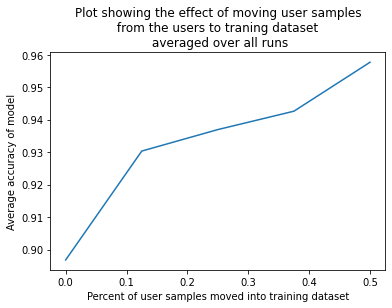

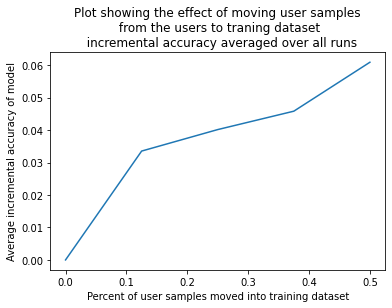

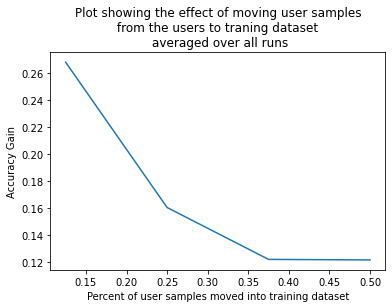

In [ ]:
plot_results(acc_result, percent_mix_end = .5, percent_mix_num_samples = 5)


The above plots clearly show an improvement in model accuracy when samples are shifted from the test dataset to the training dataset

Re-run the experiment with test and training data containing samples from all users to ensure that the gains seen in the previous experiment are due to the mixing of users, rather than the model simply beein trained with addtional samples.


In [ ]:
#acc_result = run_mix(model_har=model_har, percent_mix_end = .5, percent_mix_num_samples = 10, num_of_mix_runs = 20, mix_users=True) 
acc_result = run_mix(model_har=model_har, percent_mix_end = .5, percent_mix_num_samples = 5, num_of_mix_runs = 10, mix_users=True)

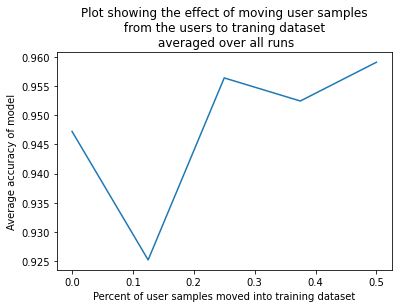

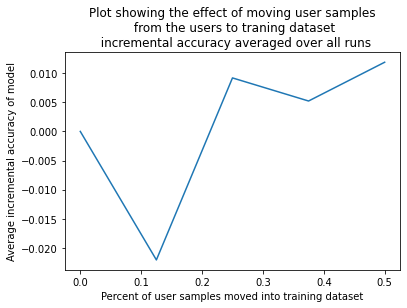

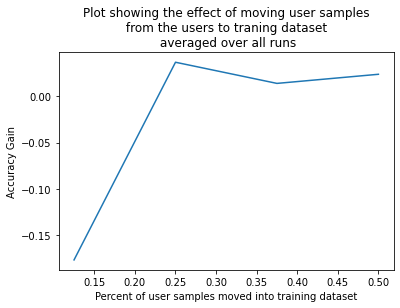

In [ ]:
plot_results(acc_result, percent_mix_end = .5, percent_mix_num_samples = 5)


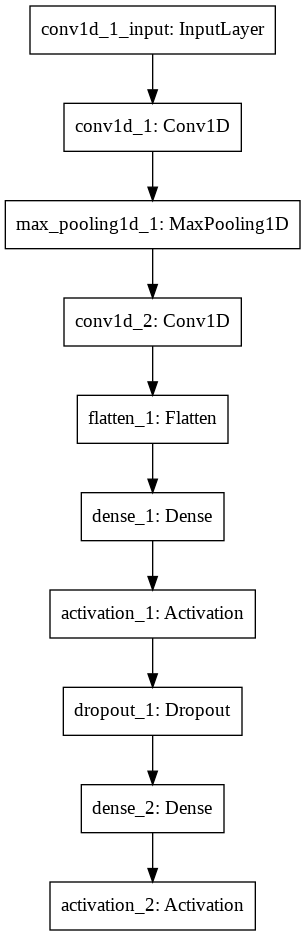

In [ ]:

plot_model(model_har)